In [189]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from pyts.multivariate.classification import MultivariateClassifier
from pyts.classification import TimeSeriesForest
from sklearn.model_selection import GridSearchCV
from joblib import Parallel, delayed
from sklearn.preprocessing import RobustScaler
from mpl_toolkits.mplot3d import Axes3D
import itertools
from sklearn.metrics import make_scorer
from sklearn.model_selection import TimeSeriesSplit
import plotly.graph_objects as go

**Loading Partition 1.**

In [190]:
main_folder_path = "/home/afrid/Documents/NASA/dataverse_files/partition1"
folder_name_1 = 'FL'
folder_name_2 = 'NF'
folder_path_1 = os.path.join(main_folder_path, folder_name_1)
folder_path_2 = os.path.join(main_folder_path, folder_name_2)
files_folder_1 = os.listdir(folder_path_1)
files_folder_2 = os.listdir(folder_path_2)


In [191]:
dfs_folder_1 = [pd.read_csv(os.path.join(folder_path_1, file), sep='\t', usecols=[1, 2, 3]).assign(Class=1) for file in files_folder_1]
dfs_folder_2 = [pd.read_csv(os.path.join(folder_path_2, file), sep='\t', usecols=[1, 2, 3]).assign(Class=0) for file in files_folder_2]

# Ensure the 'Class' column is of integer type
#for df in dfs_folder_1 + dfs_folder_2:
#    df['Class'] = df['Class'].astype(int)

In [192]:
#dfs_folder_1 = [pd.read_csv(os.path.join(folder_path_1, file), sep='\t', usecols=[1, 2, 3]) for file in files_folder_1]
#class_for_folder_1 = 1
#for df in dfs_folder_1:
#    df['Class'] = class_for_folder_1

# Read DataFrames for dfs_folder_2 and assign class 0
#dfs_folder_2 = [pd.read_csv(os.path.join(folder_path_2, file), sep='\t', usecols=[1, 2, 3]) for file in files_folder_2]
#class_for_folder_2 = 0
#for df in dfs_folder_2:
#    df['Class'] = class_for_folder_2

In [193]:
dfs_folder_1

[        TOTUSJH        TOTBSQ        TOTPOT  Class
 0   1315.120642  1.842497e+10  3.016901e+23      1
 1   1295.291384  1.843622e+10  3.024088e+23      1
 2   1291.072348  1.843172e+10  3.019023e+23      1
 3   1276.641067  1.844119e+10  2.997206e+23      1
 4   1290.970251  1.841171e+10  2.985437e+23      1
 5   1293.590838  1.843164e+10  2.966865e+23      1
 6   1272.951275  1.839969e+10  2.962582e+23      1
 7   1260.575999  1.844800e+10  2.966335e+23      1
 8   1281.635682  1.845266e+10  2.981304e+23      1
 9   1292.844758  1.841033e+10  2.974943e+23      1
 10  1311.260373  1.839432e+10  2.982796e+23      1
 11  1307.714358  1.840750e+10  2.987843e+23      1
 12  1293.290871  1.847443e+10  3.011469e+23      1
 13  1306.754047  1.849136e+10  3.032904e+23      1
 14  1302.369925  1.840407e+10  2.984461e+23      1
 15  1283.966047  1.829537e+10  2.968181e+23      1
 16  1289.318672  1.840324e+10  2.993820e+23      1
 17  1272.715353  1.836994e+10  2.973191e+23      1
 18  1283.96

In [194]:
data_folder_1 = np.stack([df.values for df in dfs_folder_1], axis=0)
data_folder_2 = np.stack([df.values for df in dfs_folder_2], axis=0)

print("Data types after loading CSV files:")
print(dfs_folder_1[0].dtypes)
print(dfs_folder_2[0].dtypes)


'''# Assign classes to entire subarrays
class_for_folder_1 = 1
class_for_folder_2 = 0

# Apply logic to assign one class label for each entire subarray
labels_folder_1 = np.full(data_folder_1.shape[0], class_for_folder_1)
labels_folder_2 = np.full(data_folder_2.shape[0], class_for_folder_2)

# Verify the data types after loading CSV files
print("Data types after loading CSV files:")
print(dfs_folder_1[0].dtypes)
print(dfs_folder_2[0].dtypes)

# Add 'Class' column to the 3D arrays
class_values_folder_1 = np.expand_dims(labels_folder_1, axis=(1, 2))
class_values_folder_2 = np.expand_dims(labels_folder_2, axis=(1, 2))

data_folder_1 = np.concatenate([data_folder_1, class_values_folder_1], axis=2)
data_folder_2 = np.concatenate([data_folder_2, class_values_folder_2], axis=2)'''

Data types after loading CSV files:
TOTUSJH    float64
TOTBSQ     float64
TOTPOT     float64
Class        int64
dtype: object
TOTUSJH    float64
TOTBSQ     float64
TOTPOT     float64
Class        int64
dtype: object


'# Assign classes to entire subarrays\nclass_for_folder_1 = 1\nclass_for_folder_2 = 0\n\n# Apply logic to assign one class label for each entire subarray\nlabels_folder_1 = np.full(data_folder_1.shape[0], class_for_folder_1)\nlabels_folder_2 = np.full(data_folder_2.shape[0], class_for_folder_2)\n\n# Verify the data types after loading CSV files\nprint("Data types after loading CSV files:")\nprint(dfs_folder_1[0].dtypes)\nprint(dfs_folder_2[0].dtypes)\n\n# Add \'Class\' column to the 3D arrays\nclass_values_folder_1 = np.expand_dims(labels_folder_1, axis=(1, 2))\nclass_values_folder_2 = np.expand_dims(labels_folder_2, axis=(1, 2))\n\ndata_folder_1 = np.concatenate([data_folder_1, class_values_folder_1], axis=2)\ndata_folder_2 = np.concatenate([data_folder_2, class_values_folder_2], axis=2)'

In [195]:
data_folder_1

array([[[1.31512064e+03, 1.84249705e+10, 3.01690142e+23, 1.00000000e+00],
        [1.29529138e+03, 1.84362189e+10, 3.02408756e+23, 1.00000000e+00],
        [1.29107235e+03, 1.84317213e+10, 3.01902259e+23, 1.00000000e+00],
        ...,
        [1.26301717e+03, 1.70505430e+10, 2.86850258e+23, 1.00000000e+00],
        [1.25975811e+03, 1.70497188e+10, 2.87663620e+23, 1.00000000e+00],
        [1.26777601e+03, 1.70489327e+10, 2.88869871e+23, 1.00000000e+00]],

       [[1.69928306e+03, 1.89409482e+10, 3.39950428e+23, 1.00000000e+00],
        [1.70093419e+03, 1.88158286e+10, 3.39971390e+23, 1.00000000e+00],
        [1.68612987e+03, 1.87045488e+10, 3.39017681e+23, 1.00000000e+00],
        ...,
        [1.75297986e+03, 1.91046967e+10, 3.47880711e+23, 1.00000000e+00],
        [1.77367458e+03, 1.93368172e+10, 3.52739906e+23, 1.00000000e+00],
        [1.83538591e+03, 1.96835259e+10, 3.58910389e+23, 1.00000000e+00]],

       [[4.09370433e+03, 6.38030309e+10, 1.06127205e+24, 1.00000000e+00],
        

In [196]:
'''# Extract class values and add to the 3D arrays
class_values_folder_1 = np.tile(class_for_folder_1, (data_folder_1.shape[0], data_folder_1.shape[1], 1))
class_values_folder_2 = np.tile(class_for_folder_2, (data_folder_2.shape[0], data_folder_2.shape[1], 1))

data_folder_1 = np.concatenate([data_folder_1, class_values_folder_1], axis=2)
data_folder_2 = np.concatenate([data_folder_2, class_values_folder_2], axis=2)'''

'# Extract class values and add to the 3D arrays\nclass_values_folder_1 = np.tile(class_for_folder_1, (data_folder_1.shape[0], data_folder_1.shape[1], 1))\nclass_values_folder_2 = np.tile(class_for_folder_2, (data_folder_2.shape[0], data_folder_2.shape[1], 1))\n\ndata_folder_1 = np.concatenate([data_folder_1, class_values_folder_1], axis=2)\ndata_folder_2 = np.concatenate([data_folder_2, class_values_folder_2], axis=2)'

In [197]:
data_folder_1

array([[[1.31512064e+03, 1.84249705e+10, 3.01690142e+23, 1.00000000e+00],
        [1.29529138e+03, 1.84362189e+10, 3.02408756e+23, 1.00000000e+00],
        [1.29107235e+03, 1.84317213e+10, 3.01902259e+23, 1.00000000e+00],
        ...,
        [1.26301717e+03, 1.70505430e+10, 2.86850258e+23, 1.00000000e+00],
        [1.25975811e+03, 1.70497188e+10, 2.87663620e+23, 1.00000000e+00],
        [1.26777601e+03, 1.70489327e+10, 2.88869871e+23, 1.00000000e+00]],

       [[1.69928306e+03, 1.89409482e+10, 3.39950428e+23, 1.00000000e+00],
        [1.70093419e+03, 1.88158286e+10, 3.39971390e+23, 1.00000000e+00],
        [1.68612987e+03, 1.87045488e+10, 3.39017681e+23, 1.00000000e+00],
        ...,
        [1.75297986e+03, 1.91046967e+10, 3.47880711e+23, 1.00000000e+00],
        [1.77367458e+03, 1.93368172e+10, 3.52739906e+23, 1.00000000e+00],
        [1.83538591e+03, 1.96835259e+10, 3.58910389e+23, 1.00000000e+00]],

       [[4.09370433e+03, 6.38030309e+10, 1.06127205e+24, 1.00000000e+00],
        

In [198]:
print("Data types after loading CSV files:")
print(dfs_folder_1[0].dtypes)
print(dfs_folder_2[0].dtypes)



Data types after loading CSV files:
TOTUSJH    float64
TOTBSQ     float64
TOTPOT     float64
Class        int64
dtype: object
TOTUSJH    float64
TOTBSQ     float64
TOTPOT     float64
Class        int64
dtype: object


In [199]:
data_folder_1[:, :, -1] = data_folder_1[:, :, -1].astype(int)
data_folder_2[:, :, -1] = data_folder_2[:, :, -1].astype(int)


print("Data types after conversion:")
print(data_folder_1[:, :, -1].dtype)
print(data_folder_2[:, :, -1].dtype)


Data types after conversion:
float64
float64


In [200]:
data_folder_1

array([[[1.31512064e+03, 1.84249705e+10, 3.01690142e+23, 1.00000000e+00],
        [1.29529138e+03, 1.84362189e+10, 3.02408756e+23, 1.00000000e+00],
        [1.29107235e+03, 1.84317213e+10, 3.01902259e+23, 1.00000000e+00],
        ...,
        [1.26301717e+03, 1.70505430e+10, 2.86850258e+23, 1.00000000e+00],
        [1.25975811e+03, 1.70497188e+10, 2.87663620e+23, 1.00000000e+00],
        [1.26777601e+03, 1.70489327e+10, 2.88869871e+23, 1.00000000e+00]],

       [[1.69928306e+03, 1.89409482e+10, 3.39950428e+23, 1.00000000e+00],
        [1.70093419e+03, 1.88158286e+10, 3.39971390e+23, 1.00000000e+00],
        [1.68612987e+03, 1.87045488e+10, 3.39017681e+23, 1.00000000e+00],
        ...,
        [1.75297986e+03, 1.91046967e+10, 3.47880711e+23, 1.00000000e+00],
        [1.77367458e+03, 1.93368172e+10, 3.52739906e+23, 1.00000000e+00],
        [1.83538591e+03, 1.96835259e+10, 3.58910389e+23, 1.00000000e+00]],

       [[4.09370433e+03, 6.38030309e+10, 1.06127205e+24, 1.00000000e+00],
        

In [201]:
final_data = np.concatenate([data_folder_1, data_folder_2], axis=0)

In [202]:
fifth_subarray = data_folder_1[4]

missing_values_present = np.isnan(fifth_subarray).any()

if missing_values_present:
    print("Missing values present in the 5th subarray of data_folder_1.")
else:
    print("No missing values in the 5th subarray of data_folder_1.")


Missing values present in the 5th subarray of data_folder_1.


In [203]:
subarrays_with_missing_values = []
for i, subarray in enumerate(final_data):
    missing_values_present = np.isnan(subarray).any()
    if missing_values_present:
        subarrays_with_missing_values.append(i)
#if subarrays_with_missing_values:
#    print("Subarrays with missing values in final_data:", subarrays_with_missing_values)
#else:
#    print("No subarrays with missing values in final_data.")

In [204]:
#for i, subarray in enumerate(final_data):
#    print(f"Subarray {i + 1} shape:", np.array(subarray).shape)

In [205]:
subarrays_with_missing_values = []
for i, subarray in enumerate(final_data):
    subarray = np.array(subarray)
    missing_values_present = np.isnan(subarray)
    if np.any(missing_values_present):
        subarrays_with_missing_values.append(i)
        column_means = np.nanmean(subarray, axis=0)
        for j in range(subarray.shape[1]):
            subarray[:, j][missing_values_present[:, j]] = column_means[j]
        final_data[i] = subarray.tolist()

#if subarrays_with_missing_values:
#    print("Subarrays with missing values in final_data:", subarrays_with_missing_values)
#    print("Imputed final_data:")
#    print(np.array(final_data))
#else:
#    print("No subarrays with missing values in final_data.")

In [206]:
missing_values_per_array = [
    np.any(np.isnan(array)) for array in final_data
]

#for i, has_missing_values in enumerate(missing_values_per_array):
#    if has_missing_values:
#        print(f"2D array {i + 1} has missing values.")
#    else:
#        print(f"2D array {i + 1} has no missing values.")

In [207]:
#data_folder_1[4]

In [208]:
data_folder_1.shape

(1254, 60, 4)

In [209]:
data_folder_2.shape

(72238, 60, 4)

In [210]:
final_data.shape

(73492, 60, 4)

In [211]:
#final_data

**Loading Partition 2.**

In [212]:

main_folder_path_p2 = "/home/afrid/Documents/NASA/dataverse_files/partition2"
folder_name_FL_p2 = 'FL'
folder_name_NF_p2 = 'NF'

folder_path_FL_p2 = os.path.join(main_folder_path_p2, folder_name_FL_p2)
folder_path_NF_p2 = os.path.join(main_folder_path_p2, folder_name_NF_p2)
files_FL_p2 = os.listdir(folder_path_FL_p2)
files_NF_p2 = os.listdir(folder_path_NF_p2)


In [213]:
dfs_FL_p2 = [pd.read_csv(os.path.join(folder_path_FL_p2, file), sep='\t', usecols=[1, 2, 3]).assign(Class=1) for file in files_FL_p2]
dfs_NF_p2 = [pd.read_csv(os.path.join(folder_path_NF_p2, file), sep='\t', usecols=[1, 2, 3]).assign(Class=0) for file in files_NF_p2]
data_FL_p2 = np.stack([df.values for df in dfs_FL_p2], axis=0)
data_NF_p2 = np.stack([df.values for df in dfs_NF_p2], axis=0)
data_FL_p2[:, :, -1] = data_FL_p2[:, :, -1].astype(int)
data_NF_p2[:, :, -1] = data_NF_p2[:, :, -1].astype(int)

In [214]:
final_data_p2 = np.concatenate([data_FL_p2, data_NF_p2], axis=0)

In [215]:
'''missing_values_FL_p2 = [
    np.any(np.isnan(array)) for array in final_data_p2
]

for i, has_missing_values in enumerate(missing_values_FL_p2):
    if has_missing_values:
        print(f"Partition 2, FL, 2D array {i + 1} has missing values.")
    else:
        print(f"Partition 2, FL, 2D array {i + 1} has no missing values.")
'''

'missing_values_FL_p2 = [\n    np.any(np.isnan(array)) for array in final_data_p2\n]\n\nfor i, has_missing_values in enumerate(missing_values_FL_p2):\n    if has_missing_values:\n        print(f"Partition 2, FL, 2D array {i + 1} has missing values.")\n    else:\n        print(f"Partition 2, FL, 2D array {i + 1} has no missing values.")\n'

In [216]:
subarrays_with_missing_values_NF_p2 = []

for i, subarray in enumerate(final_data_p2):
    subarray_NF_p2 = np.array(subarray)
    missing_values_present_NF_p2 = np.isnan(subarray_NF_p2)

    if np.any(missing_values_present_NF_p2):
        subarrays_with_missing_values_NF_p2.append(i)
        column_means_NF_p2 = np.nanmean(subarray_NF_p2, axis=0)
        for j_NF_p2 in range(subarray_NF_p2.shape[1]):
            subarray_NF_p2[:, j_NF_p2][missing_values_present_NF_p2[:, j_NF_p2]] = column_means_NF_p2[j_NF_p2]
        final_data_p2[i] = subarray_NF_p2.tolist()
        
'''if subarrays_with_missing_values_NF_p2:
    print("Partition 2, NF, Subarrays with missing values:", subarrays_with_missing_values_NF_p2)
    print("Imputed final_data_p2:")
    print(np.array(final_data_p2))
else:
    print("Partition 2, NF, No subarrays with missing values.")'''

'if subarrays_with_missing_values_NF_p2:\n    print("Partition 2, NF, Subarrays with missing values:", subarrays_with_missing_values_NF_p2)\n    print("Imputed final_data_p2:")\n    print(np.array(final_data_p2))\nelse:\n    print("Partition 2, NF, No subarrays with missing values.")'

**Sampling.**

partition 1

In [217]:

class_labels = final_data[:, 0, -1]
class_0_indices = np.where(class_labels == 0)[0]
class_1_indices = np.where(class_labels == 1)[0]
selected_class_0_indices = class_0_indices[:len(class_1_indices)]
selected_indices = np.concatenate([class_1_indices, selected_class_0_indices])
final_train_data = final_data[selected_indices]
final_train_data[:, 0, -1] = final_train_data[:, 0, -1].astype(int)

print(final_train_data.shape)

(2508, 60, 4)


partition 2

In [218]:

'''class_labels_p2 = final_data_p2[:, 0, -1]
class_0_indices_p2 = np.where(class_labels_p2 == 0)[0]
class_1_indices_p2 = np.where(class_labels_p2 == 1)[0]
selected_class_0_indices_p2 = class_0_indices_p2[:len(class_1_indices_p2)]
selected_indices_p2 = np.concatenate([class_1_indices_p2, selected_class_0_indices_p2])
final_test_data_p2 = final_data_p2[selected_indices_p2]
final_test_data_p2[:, 0, -1] = final_test_data_p2[:, 0, -1].astype(int)


print(final_test_data_p2.shape)'''

'class_labels_p2 = final_data_p2[:, 0, -1]\nclass_0_indices_p2 = np.where(class_labels_p2 == 0)[0]\nclass_1_indices_p2 = np.where(class_labels_p2 == 1)[0]\nselected_class_0_indices_p2 = class_0_indices_p2[:len(class_1_indices_p2)]\nselected_indices_p2 = np.concatenate([class_1_indices_p2, selected_class_0_indices_p2])\nfinal_test_data_p2 = final_data_p2[selected_indices_p2]\nfinal_test_data_p2[:, 0, -1] = final_test_data_p2[:, 0, -1].astype(int)\n\n\nprint(final_test_data_p2.shape)'

Model Example.

In [219]:
#pip install pyts


In [220]:
X_train = final_train_data[:, :, :-1]
y_train = final_train_data[:, 0, -1]

X_test = final_data_p2[:, :, :-1]
y_test = final_data_p2[:, 0, -1]

In [221]:
y_train = y_train.astype(int)
y_test = y_test.astype(int)

In [222]:
y_test.shape

(88558,)

In [223]:
#X_train

In [224]:
#scaler = RobustScaler()
#scaler.fit(X_train)

#X_train = scaler.transform(X_train)
#X_test = scaler.transform(X_test)

In [225]:

#X_train = X_train.reshape(-1, X_train.shape[1] * X_train.shape[2])
#X_test = X_test.reshape(-1, X_test.shape[1] * X_test.shape[2])


In [226]:

X_train.shape
X_test.shape
y_train.shape
y_test.shape

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)


(2508, 60, 3)
(88558, 60, 3)
(2508,)
(88558,)


In [227]:
np.unique(y_test)

array([0, 1])

In [228]:
#classifier = TimeSeriesForest(n_estimators=100, random_state=42)
#classifier.fit(X_train, y_train)


#clf = MultivariateClassifier(estimator=TimeSeriesForest(n_estimators=100,n_windows=5, max_depth=None, random_state=53))
#clf.fit(X_train, y_train)



In [229]:
'''def tss_score(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    TN, FP, FN, TP = cm.ravel()
    P = TP + FN
    N = FP + TN
    return (TP/P) - (FP/N)


def hss_score(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    TN, FP, FN, TP = cm.ravel()
    P = TP + FN
    N = FP + TN
    return (2 * ((TP * TN) - (FN * FP))) / ( (P * (FN + TN)) + (N * (TP + FP)) )
'''

In [230]:
'''param_grid = {
    'n_estimators': [100, 200, 300],
    'window_length': [5, 10, 20],
    'max_depth': [5, 7, None],
    'random_state': [42]
}

scorer = {'tss_score': tss_score, 'hss_score': hss_score}


grid_search = GridSearchCV(estimator=MultivariateClassifier(estimator=TimeSeriesForest()),
                           param_grid=param_grid,
                           scoring=None,
                           verbose=2)

#grid_search.fit(X_train, y_train)
'''

"param_grid = {\n    'n_estimators': [100, 200, 300],\n    'window_length': [5, 10, 20],\n    'max_depth': [5, 7, None],\n    'random_state': [42]\n}\n\nscorer = {'tss_score': tss_score, 'hss_score': hss_score}\n\n\ngrid_search = GridSearchCV(estimator=MultivariateClassifier(estimator=TimeSeriesForest()),\n                           param_grid=param_grid,\n                           scoring=None,\n                           verbose=2)\n\n#grid_search.fit(X_train, y_train)\n"

In [231]:
'''results = {"params": [], "tss_scores": [], "hss_scores": []}

# Fit the model and access predictions within the loop
for index, params in enumerate(grid_search.param_grid):

    # No need for string conversion or eval:
    param_dict = {"n_estimators": params["n_estimators"],
                 "window_length": params["window_length"],
                 "max_depth": params["max_depth"],
                 "random_state": params["random_state"]}

    grid_search.estimator.set_params(**param_dict)
    grid_search.fit(X_train, y_train)
    y_pred = grid_search.predict(X_test)  # Get predictions

    # Calculate TSS and HSS scores (replace with your actual implementations)
    tss = tss_score(y_test, y_pred)
    hss = hss_score(y_test, y_pred)

    # Store results
    results["params"].append(params)
    results["tss_scores"].append(tss)
    results["hss_scores"].append(hss)

# Access and analyze results
for i, params in enumerate(results["params"]):
    print(f"Parameters: {params}")
    print(f"TSS score: {results['tss_scores'][i]}")
    print(f"HSS score: {results['hss_scores'][i]}\n")'''

'results = {"params": [], "tss_scores": [], "hss_scores": []}\n\n# Fit the model and access predictions within the loop\nfor index, params in enumerate(grid_search.param_grid):\n\n    # No need for string conversion or eval:\n    param_dict = {"n_estimators": params["n_estimators"],\n                 "window_length": params["window_length"],\n                 "max_depth": params["max_depth"],\n                 "random_state": params["random_state"]}\n\n    grid_search.estimator.set_params(**param_dict)\n    grid_search.fit(X_train, y_train)\n    y_pred = grid_search.predict(X_test)  # Get predictions\n\n    # Calculate TSS and HSS scores (replace with your actual implementations)\n    tss = tss_score(y_test, y_pred)\n    hss = hss_score(y_test, y_pred)\n\n    # Store results\n    results["params"].append(params)\n    results["tss_scores"].append(tss)\n    results["hss_scores"].append(hss)\n\n# Access and analyze results\nfor i, params in enumerate(results["params"]):\n    print(f"Param

In [232]:
n_estimators_values = [100, 200, 300]
n_windows_values = [5]
max_depth_values = [None]

results = {"params": [], "tss_scores": [], "hss_scores": []}

for n_estimators in n_estimators_values:
    for n_windows in n_windows_values:
        for max_depth in max_depth_values:
            clf = MultivariateClassifier(estimator=TimeSeriesForest(
                n_estimators=n_estimators, n_windows=n_windows, max_depth=max_depth,random_state=53
            ))
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            tss = tss_score(y_test, y_pred)
            hss = hss_score(y_test, y_pred)
            results["params"].append({
                "n_estimators": n_estimators,
                "n_windows": n_windows,
                "max_depth": max_depth
            })
            results["tss_scores"].append(tss)
            results["hss_scores"].append(hss)
            print(f"Parameters: {results['params'][-1]}")
            print(f"TSS score: {tss:.3f}") 
            print(f"HSS score: {hss:.3f}\n")


Parameters: {'n_estimators': 100, 'n_windows': 5, 'max_depth': None}
TSS score: 0.744
HSS score: 0.139

Parameters: {'n_estimators': 200, 'n_windows': 5, 'max_depth': None}
TSS score: 0.740
HSS score: 0.138

Parameters: {'n_estimators': 300, 'n_windows': 5, 'max_depth': None}
TSS score: 0.743
HSS score: 0.138



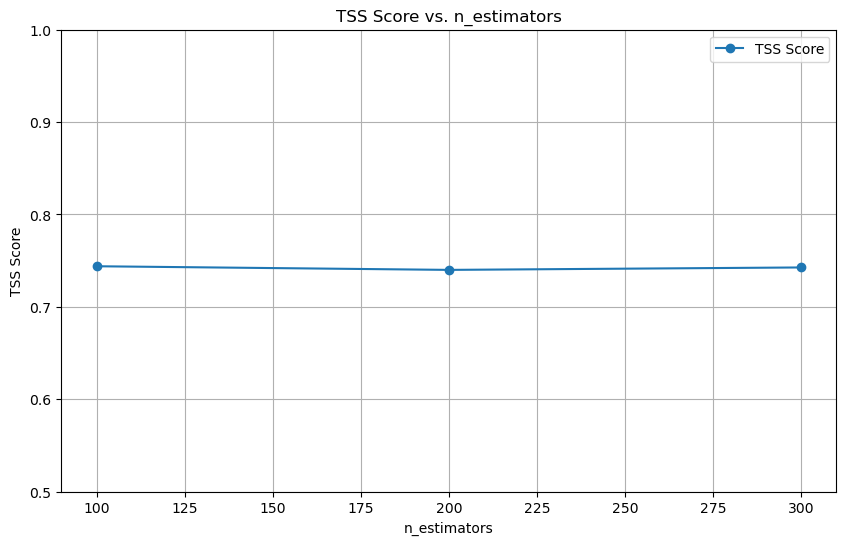

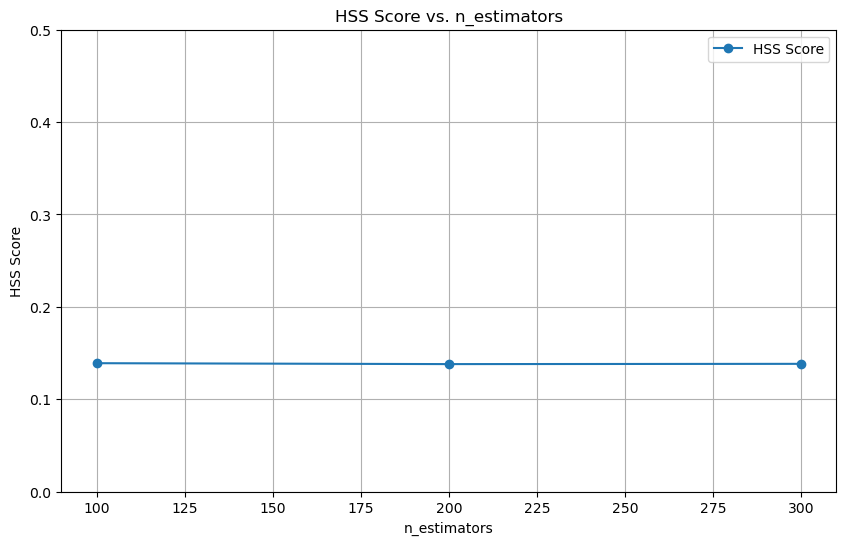

In [233]:

plt.figure(figsize=(10, 6))
plt.plot(n_estimators_values, results["tss_scores"], marker='o', label='TSS Score')
plt.xlabel('n_estimators')
plt.ylabel('TSS Score')
plt.ylim(0.5, 1) 
plt.title('TSS Score vs. n_estimators')
plt.legend()
plt.grid(True)
plt.show()


plt.figure(figsize=(10, 6))
plt.plot(n_estimators_values, results["hss_scores"], marker='o', label='HSS Score')
plt.xlabel('n_estimators')
plt.ylabel('HSS Score')
plt.ylim(0, 0.5) 
plt.title('HSS Score vs. n_estimators')
plt.legend()
plt.grid(True)
plt.show()


In [234]:
'''def tss_score(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    TN, FP, FN, TP = cm.ravel()
    P = TP + FN
    N = FP + TN
    return (TP/P) - (FP/N)


def hss_score(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    TN, FP, FN, TP = cm.ravel()
    P = TP + FN
    N = FP + TN
    return (2 * ((TP * TN) - (FN * FP))) / ( (P * (FN + TN)) + (N * (TP + FP)) )'''

In [235]:
'''import itertools

n_estimators = [100, 200, 300]
n_windows = [5, 10, 20]
max_depth = [None, 5]

def evaluate_params(params):
    n_estimators, n_windows, max_depth = params
    params_dict = {
        "n_estimators": n_estimators,
        "n_windows": n_windows,
        "max_depth": max_depth
    }

    clf = MultivariateClassifier(estimator = TimeSeriesForest(n_estimators=n_estimators, n_windows=n_windows, max_depth=max_depth, random_state=53))
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    tss = tss_score(y_test, y_pred)
    hss = hss_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    return {
        "params": params,
        "tss_score": tss,
        "hss_score": hss,
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1
    }


results = Parallel(n_jobs=-1)(
    delayed(evaluate_params)(params)
    for params in itertools.product(n_estimators, n_windows, max_depth)
)
for result in results:
    print(f"Parameters: {result['params']}")
    print(f"TSS score: {result['tss_score']:.3f}")
    print(f"HSS score: {result['hss_score']:.3f}")
    print(f"Accuracy: {result['accuracy']:.3f}")
    print(f"Precision: {result['precision']:.3f}")
    print(f"Recall: {result['recall']:.3f}")
    print(f"F1 score: {result['f1_score']:.3f}")
    print("\n")'''

'import itertools\n\nn_estimators = [100, 200, 300]\nn_windows = [5, 10, 20]\nmax_depth = [None, 5]\n\ndef evaluate_params(params):\n    n_estimators, n_windows, max_depth = params\n    params_dict = {\n        "n_estimators": n_estimators,\n        "n_windows": n_windows,\n        "max_depth": max_depth\n    }\n\n    clf = MultivariateClassifier(estimator = TimeSeriesForest(n_estimators=n_estimators, n_windows=n_windows, max_depth=max_depth, random_state=53))\n    clf.fit(X_train, y_train)\n    y_pred = clf.predict(X_test)\n    tss = tss_score(y_test, y_pred)\n    hss = hss_score(y_test, y_pred)\n    accuracy = accuracy_score(y_test, y_pred)\n    precision = precision_score(y_test, y_pred)\n    recall = recall_score(y_test, y_pred)\n    f1 = f1_score(y_test, y_pred)\n\n    return {\n        "params": params,\n        "tss_score": tss,\n        "hss_score": hss,\n        "accuracy": accuracy,\n        "precision": precision,\n        "recall": recall,\n        "f1_score": f1\n    }\n\n

In [236]:

'''tss_scores = []
parameter_combinations = []


for params in itertools.product(n_estimators, n_windows, max_depth):
    result = evaluate_params(params)
    tss_scores.append(result['tss_score'])
    parameter_combinations.append(params)

tss_scores = np.array(tss_scores)
parameter_combinations = np.array(parameter_combinations)'''

"tss_scores = []\nparameter_combinations = []\n\n\nfor params in itertools.product(n_estimators, n_windows, max_depth):\n    result = evaluate_params(params)\n    tss_scores.append(result['tss_score'])\n    parameter_combinations.append(params)\n\ntss_scores = np.array(tss_scores)\nparameter_combinations = np.array(parameter_combinations)"

In [237]:

'''n_estimators_vals = [result['params'][0] for result in results]
n_windows_vals = [result['params'][1] for result in results]
max_depth_vals = [result['params'][2] if result['params'][2] is not None else np.nan for result in results]
tss_scores = [result['tss_score'] for result in results if result['tss_score'] is not None]


print("None values in tss_scores:", [score is None for score in tss_scores])'''


'n_estimators_vals = [result[\'params\'][0] for result in results]\nn_windows_vals = [result[\'params\'][1] for result in results]\nmax_depth_vals = [result[\'params\'][2] if result[\'params\'][2] is not None else np.nan for result in results]\ntss_scores = [result[\'tss_score\'] for result in results if result[\'tss_score\'] is not None]\n\n\nprint("None values in tss_scores:", [score is None for score in tss_scores])'

In [238]:
'''# Create a scatter plot
#fig = plt.figure()
#ax = fig.add_subplot(111, projection='3d')
#sc = ax.scatter(n_estimators_vals, n_windows_vals, max_depth_vals, c=tss_scores, cmap='viridis', marker='o')


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_trisurf(n_estimators_vals, n_windows_vals, tss_scores, cmap='viridis')


ax.set_xlabel('n_estimators')
ax.set_ylabel('n_windows')
ax.set_zlabel('max_depth')
ax.set_title('TSS Scores for Different Parameter Combinations')


cbar = fig.colorbar(sc)
cbar.set_label('TSS Score')

plt.show()'''

"# Create a scatter plot\n#fig = plt.figure()\n#ax = fig.add_subplot(111, projection='3d')\n#sc = ax.scatter(n_estimators_vals, n_windows_vals, max_depth_vals, c=tss_scores, cmap='viridis', marker='o')\n\n\nfig = plt.figure()\nax = fig.add_subplot(111, projection='3d')\nax.plot_trisurf(n_estimators_vals, n_windows_vals, tss_scores, cmap='viridis')\n\n\nax.set_xlabel('n_estimators')\nax.set_ylabel('n_windows')\nax.set_zlabel('max_depth')\nax.set_title('TSS Scores for Different Parameter Combinations')\n\n\ncbar = fig.colorbar(sc)\ncbar.set_label('TSS Score')\n\nplt.show()"

In [239]:

'''n_estimators_vals = [result['params'][0] for result in results]
n_windows_vals = [result['params'][1] for result in results]
max_depth_vals = [result['params'][2] for result in results]
tss_scores = [result['tss_score'] if result['tss_score'] is not None else np.nan for result in results]


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(n_estimators_vals, n_windows_vals, max_depth_vals, c=tss_scores, cmap='viridis', marker='o')

ax.set_xlabel('n_estimators')
ax.set_ylabel('n_windows')
ax.set_zlabel('max_depth')
ax.set_title('TSS Scores for Different Parameter Combinations')


cbar = fig.colorbar(sc)
cbar.set_label('TSS Score')


plt.show()'''

"n_estimators_vals = [result['params'][0] for result in results]\nn_windows_vals = [result['params'][1] for result in results]\nmax_depth_vals = [result['params'][2] for result in results]\ntss_scores = [result['tss_score'] if result['tss_score'] is not None else np.nan for result in results]\n\n\nfig = plt.figure()\nax = fig.add_subplot(111, projection='3d')\nsc = ax.scatter(n_estimators_vals, n_windows_vals, max_depth_vals, c=tss_scores, cmap='viridis', marker='o')\n\nax.set_xlabel('n_estimators')\nax.set_ylabel('n_windows')\nax.set_zlabel('max_depth')\nax.set_title('TSS Scores for Different Parameter Combinations')\n\n\ncbar = fig.colorbar(sc)\ncbar.set_label('TSS Score')\n\n\nplt.show()"

In [240]:
'''tss_scores = [result["tss_score"] for result in results]
hss_scores = [result["hss_score"] for result in results]
params_list = [result["params"] for result in results]

n_estimators_vals, n_windows_vals, max_depth_vals = zip(*params_list)

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 12))  # Adjust figure size as needed

axes[0, 0].plot(n_estimators_vals, tss_scores, marker="o", linestyle="--", label="n_estimators")
axes[0, 1].plot(n_windows_vals, tss_scores, marker="o", linestyle="--", label="n_windows")
axes[0, 2].plot(max_depth_vals, tss_scores, marker="o", linestyle="--", label="max_depth")
axes[0, 0].set_title("TSS vs. n_estimators")
axes[0, 1].set_title("TSS vs. n_windows")
axes[0, 2].set_title("TSS vs. max_depth")

axes[1, 0].plot(n_estimators_vals, hss_scores, marker="o", linestyle="--", label="n_estimators")
axes[1, 1].plot(n_windows_vals, hss_scores, marker="o", linestyle="--", label="n_windows")
axes[1, 2].plot(max_depth_vals, hss_scores, marker="o", linestyle="--", label="max_depth")
axes[1, 0].set_title("HSS vs. n_estimators")
axes[1, 1].set_title("HSS vs. n_windows")
axes[1, 2].set_title("HSS vs. max_depth")

for ax in axes.flat:
    ax.legend()
plt.suptitle("TSS and HSS Scores for Different Parameter Values", fontsize=16)

plt.tight_layout()
plt.show()'''


'tss_scores = [result["tss_score"] for result in results]\nhss_scores = [result["hss_score"] for result in results]\nparams_list = [result["params"] for result in results]\n\nn_estimators_vals, n_windows_vals, max_depth_vals = zip(*params_list)\n\nfig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 12))  # Adjust figure size as needed\n\naxes[0, 0].plot(n_estimators_vals, tss_scores, marker="o", linestyle="--", label="n_estimators")\naxes[0, 1].plot(n_windows_vals, tss_scores, marker="o", linestyle="--", label="n_windows")\naxes[0, 2].plot(max_depth_vals, tss_scores, marker="o", linestyle="--", label="max_depth")\naxes[0, 0].set_title("TSS vs. n_estimators")\naxes[0, 1].set_title("TSS vs. n_windows")\naxes[0, 2].set_title("TSS vs. max_depth")\n\naxes[1, 0].plot(n_estimators_vals, hss_scores, marker="o", linestyle="--", label="n_estimators")\naxes[1, 1].plot(n_windows_vals, hss_scores, marker="o", linestyle="--", label="n_windows")\naxes[1, 2].plot(max_depth_vals, hss_scores, marker

In [246]:


'''def tss_scorer(estimator, X, y):
    y_pred = estimator.predict(X)
    cm = confusion_matrix(y, y_pred)
    TN, FP, FN, TP = cm[0, 0], cm[0, 1], cm[1, 0], cm[1, 1]
    P = TP + FN
    N = FP + TN
    return (TP / P) - (FP / N) if (P > 0 and N > 0) else 0


def hss_scorer(estimator, X, y):
    y_pred = estimator.predict(X)
    cm = confusion_matrix(y, y_pred)
    TN, FP, FN, TP = cm.ravel()
    P = TP + FN
    N = FP + TN
    return (2 * ((TP * TN) - (FN * FP))) / ((P * (FN + TN)) + (N * (TP + FP))) if (P > 0 and N > 0) else 0'''


In [255]:
def tss_score(estimator, X, y):
    y_pred = estimator.predict(X)
    cm = confusion_matrix(y, y_pred)
    TN, FP, FN, TP = cm.ravel()
    P = TP + FN
    N = FP + TN
    return (TP / P) - (FP / N) if (P > 0 and N > 0) else 0

In [256]:
#tss_scorer = make_scorer(tss_score)
#hss_scorer = make_scorer(hss_score)

In [260]:
param_grid = {
    'estimator__n_estimators': [100, 150, 200],
    'estimator__n_windows': [5, 10, 15],
    'estimator__min_window_size': [1, 2, 3],
    'estimator__criterion': ['entropy'],
    'estimator__max_depth': [5, 10, 20],
}

In [261]:
clf = MultivariateClassifier(estimator=TimeSeriesForest(random_state=53))

n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

grid_search = GridSearchCV(
    estimator=clf,
    param_grid=param_grid,
    scoring=tss_score, 
    refit='tss',
    #cv=tscv,  
    n_jobs=-1,  
)



In [262]:

grid_search.fit(X_train, y_train)

/home/afrid/anaconda3/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.

/home/afrid/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning:


135 fits failed out of a total of 405.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
135 fits failed with the following error:
Traceback (most recent call last):
  File "/home/afrid/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/afrid/anaconda3/lib/python3.11/s

GridSearchCV(estimator=MultivariateClassifier(estimator=TimeSeriesForest(random_state=53)),
             n_jobs=-1,
             param_grid={'estimator__criterion': ['entropy'],
                         'estimator__max_depth': [5, 10, 20],
                         'estimator__min_window_size': [1, 2, 3],
                         'estimator__n_estimators': [100, 150, 200],
                         'estimator__n_windows': [5, 10, 15]},
             refit='tss', scoring=<function tss_score at 0x7f4daa5d2660>)

In [263]:
results_df = pd.DataFrame(grid_search.cv_results_)

In [264]:
results_df.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_estimator__criterion', 'param_estimator__max_depth',
       'param_estimator__min_window_size', 'param_estimator__n_estimators',
       'param_estimator__n_windows', 'params', 'split0_test_score',
       'split1_test_score', 'split2_test_score', 'split3_test_score',
       'split4_test_score', 'mean_test_score', 'std_test_score',
       'rank_test_score'],
      dtype='object')

In [ ]:
results_df

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       33.507804      1.489321         1.888410        0.156402   
1       37.288229      1.436465         1.516789        0.477137   
2       49.635504      0.534063         1.026388        0.050301   
3       59.534929      1.391378         1.860673        0.066629   
4       74.350071      1.455107         1.868236        0.106431   
..            ...           ...              ...             ...   
76       0.015440      0.000040         0.000000        0.000000   
77       0.015415      0.000052         0.000000        0.000000   
78       0.016165      0.000903         0.000000        0.000000   
79       0.017929      0.001953         0.000000        0.000000   
80       0.017976      0.000415         0.000000        0.000000   

   param_estimator__criterion param_estimator__max_depth  \
0                     entropy                          5   
1                     entropy                          5   
2                     entropy                          5   
3                     entropy                          5   
4                     entropy                          5   
..                        ...                        ...   
76                    entropy                         20   
77                    entropy                         20   
78                    entropy                         20   
79                    entropy                         20   
80                    entropy                         20   

   param_estimator__min_window_size param_estimator__n_estimators  \
0                                 1                           100   
1                                 1                           100   
2                                 1                           100   
3                                 1                           200   
4                                 1                           200   
..                              ...                           ...   
76                                3                           200   
77                                3                           200   
78                                3                           300   
79                                3                           300   
80                                3                           300   

   param_estimator__n_windows  \
0                           5   
1                          10   
2                          15   
3                           5   
4                          10   
..                        ...   
76                         10   
77                         15   
78                          5   
79                         10   
80                         15   

                                               params  split0_test_score  \
0   {'estimator__criterion': 'entropy', 'estimator...           0.788845   
1   {'estimator__criterion': 'entropy', 'estimator...           0.800797   
2   {'estimator__criterion': 'entropy', 'estimator...           0.820717   
3   {'estimator__criterion': 'entropy', 'estimator...           0.784861   
4   {'estimator__criterion': 'entropy', 'estimator...           0.800797   
..                                                ...                ...   
76  {'estimator__criterion': 'entropy', 'estimator...                NaN   
77  {'estimator__criterion': 'entropy', 'estimator...                NaN   
78  {'estimator__criterion': 'entropy', 'estimator...                NaN   
79  {'estimator__criterion': 'entropy', 'estimator...                NaN   
80  {'estimator__criterion': 'entropy', 'estimator...                NaN   

    split1_test_score  split2_test_score  split3_test_score  \
0            0.760956           0.737052           0.800319   
1            0.764940           0.741036           0.800335   
2            0.776892           0.745020           0.808271   
3            0.760956           0.737052           0.800319   
4           

In [266]:
print(results_df.to_string())

    mean_fit_time  std_fit_time  mean_score_time  std_score_time param_estimator__criterion param_estimator__max_depth param_estimator__min_window_size param_estimator__n_estimators param_estimator__n_windows                                                                                                                                                        params  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0       27.451201      1.237832         1.842587        0.108009                    entropy                          5                                1                           100                          5    {'estimator__criterion': 'entropy', 'estimator__max_depth': 5, 'estimator__min_window_size': 1, 'estimator__n_estimators': 100, 'estimator__n_windows': 5}           0.788845           0.760956           0.737052           0.800319           0.748558         0.767146        0.

In [267]:

print("Best Parameters:", grid_search.best_params_)
print("Best TSS:", grid_search.best_score_)



Best Parameters: {'estimator__criterion': 'entropy', 'estimator__max_depth': 20, 'estimator__min_window_size': 1, 'estimator__n_estimators': 200, 'estimator__n_windows': 15}
Best TSS: 0.8500908366533866


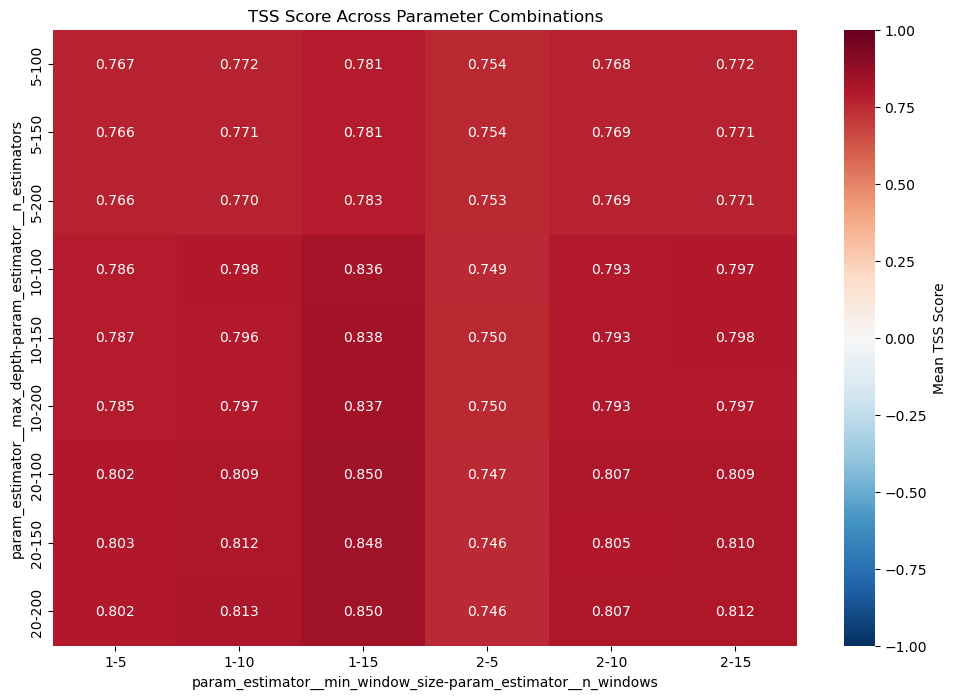

In [268]:
import seaborn as sns

heatmap_data = results_df[['param_estimator__criterion', 'param_estimator__max_depth',
                            'param_estimator__min_window_size', 'param_estimator__n_estimators',
                            'param_estimator__n_windows', 'mean_test_score']]


heatmap_data_pivot = heatmap_data.pivot_table(index=['param_estimator__max_depth', 'param_estimator__n_estimators'],
                                              columns=['param_estimator__min_window_size', 'param_estimator__n_windows'],
                                              values='mean_test_score', aggfunc='mean')


plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data_pivot, annot=True, cmap='RdBu_r', fmt=".3f", vmin=-1, vmax=1, cbar_kws={'label': 'Mean TSS Score'})
plt.title('TSS Score Across Parameter Combinations')
plt.show()


In [269]:

'''fig = go.Figure(data=[go.Surface(z=heatmap_data_pivot.values,
                                 x=heatmap_data_pivot.columns.get_level_values('param_estimator__min_window_size').values,
                                 y=heatmap_data_pivot.columns.get_level_values('param_estimator__n_windows').values,
                                 colorscale='RdBu_r',
                                 colorbar=dict(title='Mean TSS Score', tickvals=[-1, 0, 1]))])

fig.update_layout(scene=dict(zaxis=dict(range=[-1, 1])),
                  title='TSS Score Across Parameter Combinations',
                  scene_camera=dict(eye=dict(x=1.87, y=0.88, z=-0.64)))

fig.show()
'''

"fig = go.Figure(data=[go.Surface(z=heatmap_data_pivot.values,\n                                 x=heatmap_data_pivot.columns.get_level_values('param_estimator__min_window_size').values,\n                                 y=heatmap_data_pivot.columns.get_level_values('param_estimator__n_windows').values,\n                                 colorscale='RdBu_r',\n                                 colorbar=dict(title='Mean TSS Score', tickvals=[-1, 0, 1]))])\n\nfig.update_layout(scene=dict(zaxis=dict(range=[-1, 1])),\n                  title='TSS Score Across Parameter Combinations',\n                  scene_camera=dict(eye=dict(x=1.87, y=0.88, z=-0.64)))\n\nfig.show()\n"

In [270]:
# Print the levels of the MultiIndex
print(heatmap_data_pivot.columns.levels)


[[1, 2, 3], [5, 10, 15]]


In [272]:

param_combinations = grid_search.cv_results_['params']
tss_values = grid_search.cv_results_['mean_test_score']

n_windows_values = [comb['estimator__n_windows'] for comb in param_combinations]
n_estimators_values = [comb['estimator__n_estimators'] for comb in param_combinations]

labels = [f"N Windows: {n_windows}, N Estimators: {n_estimators}, TSS: {tss}" 
          for n_windows, n_estimators, tss in zip(n_windows_values, n_estimators_values, tss_values)]

fig = go.Figure(data=[go.Scatter3d(x=n_windows_values, y=n_estimators_values, z=tss_values, mode='markers',
                                   marker=dict(color=tss_values, colorscale='Viridis', colorbar=dict(title='TSS')),
                                   text=labels, hoverinfo='text')])

fig.update_layout(scene=dict(xaxis_title='N Windows', yaxis_title='N Estimators', zaxis_title='TSS'))

fig.show()


In [273]:

clf = MultivariateClassifier(estimator=TimeSeriesForest(n_estimators=100,n_windows=5, max_depth=5, min_window_size=1, random_state=53))
clf.fit(X_train, y_train)


MultivariateClassifier(estimator=TimeSeriesForest(max_depth=5, n_estimators=100,
                                                  n_windows=5,
                                                  random_state=53))

In [ ]:
'''max_depths = []
total_depth = 0
for estimator in clf.estimators_:
    for tree in estimator.estimators_:
        tree_depth = tree.get_depth()
        max_depths.append(tree_depth)
        total_depth += tree_depth

average_depth = total_depth / len(max_depths)

print("Maximum depths of individual trees:", max_depths)
print("Maximum depth across all trees:", max(max_depths))
print("Minimum depth across all trees:", min(max_depths))
print("Average depth across all trees:", round(average_depth))'''

Maximum depths of individual trees: [21, 23, 21, 26, 24, 22, 22, 24, 24, 21, 19, 25, 22, 21, 17, 21, 19, 17, 25, 25, 20, 17, 34, 20, 21, 23, 30, 19, 21, 28, 20, 19, 19, 21, 18, 26, 24, 19, 22, 21, 24, 22, 23, 19, 18, 24, 23, 20, 20, 24, 22, 20, 20, 19, 20, 23, 21, 22, 18, 22, 21, 25, 28, 21, 23, 23, 19, 23, 23, 21, 23, 24, 19, 22, 27, 22, 25, 26, 18, 22, 22, 28, 20, 21, 21, 18, 24, 26, 19, 27, 25, 20, 20, 24, 27, 20, 21, 22, 23, 20, 21, 24, 23, 22, 19, 27, 22, 26, 26, 21, 23, 27, 19, 21, 21, 20, 20, 23, 26, 23, 27, 20, 21, 20, 23, 21, 23, 25, 22, 20, 23, 18, 17, 19, 19, 21, 22, 27, 21, 20, 20, 21, 24, 19, 26, 28, 19, 23, 30, 30, 20, 24, 26, 27, 24, 22, 22, 23, 21, 22, 21, 16, 22, 31, 21, 25, 17, 33, 24, 22, 23, 21, 23, 22, 29, 29, 22, 19, 19, 21, 26, 30, 20, 22, 20, 22, 25, 25, 22, 25, 24, 21, 21, 21, 27, 27, 26, 23, 22, 20, 23, 21, 24, 24, 21, 21, 23, 21, 28, 20, 21, 20, 20, 26, 22, 28, 20, 22, 24, 22, 23, 25, 24, 23, 21, 21, 28, 33, 25, 31, 25, 20, 20, 21, 23, 23, 21, 25, 18, 18, 22,

In [274]:

y_pred = clf.predict(X_test)

In [275]:
#y_pred = classifier.predict(X_test)
report = classification_report(y_test, y_pred)
print("Classification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.86      0.93     87156
           1       0.10      0.93      0.18      1402

    accuracy                           0.86     88558
   macro avg       0.55      0.90      0.55     88558
weighted avg       0.98      0.86      0.91     88558



In [276]:
conf_matrix = confusion_matrix(y_test, y_pred)
TP = conf_matrix[1, 1]
FN = conf_matrix[1, 0]
FP = conf_matrix[0, 1]
TN = conf_matrix[0,0]
conf_matrix

array([[75076, 12080],
       [   94,  1308]])

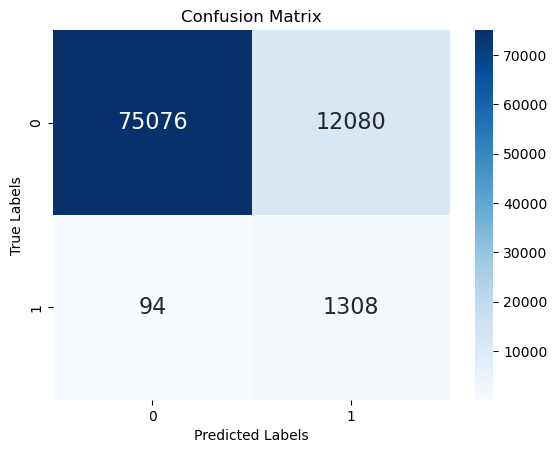

In [277]:
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 16})

# Add labels and title
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [278]:
print(TP)
print(FN)
print(FP)
print(TN)

1308
94
12080
75076


In [279]:

P = TP + FN
N = FP + TN

TSS = (TP/P) - (FP/N)

HSS2 = (2 * ((TP * TN) - (FN * FP))) / ( (P * (FN + TN)) + (N * (TP + FP)) )
print(f"True Skill Score (TSS): {TSS}")
print(f"Heidke Skill Score (HSS2): {HSS2}")


True Skill Score (TSS): 0.794350877489322
Heidke Skill Score (HSS2): 0.15258824141619332


In [280]:
'''tss = tss_score(y_test, y_pred)
hss = hss_score(y_test, y_pred)

print(tss)
print(hss)'''

'tss = tss_score(y_test, y_pred)\nhss = hss_score(y_test, y_pred)\n\nprint(tss)\nprint(hss)'

In [281]:
#TN = conf_matrix[0, 0]
#HSS = (2 * (TP * TN - FP * FN)) / ((TP + FN) * (FN + TN) + (TP + FP) * (FP + TN))


**Temporal correlation.**

In [ ]:
def temporal_correlation_analysis(data):
    num_classes = len(np.unique(data[:, 0, -1]))
    
    for class_label in range(num_classes):
        print(f"Temporal Correlation Analysis for Class {class_label}:")
        class_data = data[data[:, 0, -1] == class_label][:, :, :-1]
        
        for i in range(class_data.shape[2]):
            column_data = class_data[:, :, i].reshape(-1)
            df = pd.DataFrame({'Current': column_data[:-1], 'Next': column_data[1:]})
            temporal_correlation = df['Current'].corr(df['Next'])
            
            print(f"Column {i + 1}: Temporal Correlation = {temporal_correlation:.4f}")

temporal_correlation_analysis(final_data)

Temporal Correlation Analysis for Class 0:
Column 1: Temporal Correlation = 0.9832
Column 2: Temporal Correlation = 0.9833
Column 3: Temporal Correlation = 0.9574
Temporal Correlation Analysis for Class 1:
Column 1: Temporal Correlation = 0.9829
Column 2: Temporal Correlation = 0.9833
Column 3: Temporal Correlation = 0.9832
